In [1]:
import numpy as np
from scipy.linalg import expm, eig, norm

In [2]:
# We define Pauli matices and a helper function for tensor products of Paulis for convenience to use later.
ident = np.array([[1, 0], [0, 1]])
pauli_x = np.array([[0, 1], [1, 0]])
pauli_y = np.array([[0, -1j], [1j, 0]])
pauli_z = np.array([[1, 0], [0, -1]])


def pauli_product(pauli_string):
    """Helper method to compute kronecker product of Paulis"""

    prod = 1
    for p in pauli_string:
        if p == "I":
            prod = np.kron(prod, ident)
        elif p == "X":
            prod = np.kron(prod, pauli_x)
        elif p == "Y":
            prod = np.kron(prod, pauli_y)
        elif p == "Z":
            prod = np.kron(prod, pauli_z)

    return prod

def sortES(eigVals, eigVecs):
    """
    simple routine to sort eigenvectors given the eigenvalues
    """

    # Zip the associated eigenvalues and eigenvectors together and sort by eigenvalue
    eigSystem = sorted(zip(eigVals, np.transpose(eigVecs)), key = lambda x: x[0])
    eigValsOut = [eVal for eVal, _ in eigSystem]
    eigVecsOut = [eVec for _, eVec in eigSystem]

    return eigValsOut,eigVecsOut

def printstate(v, L, cutoff):
    """
    routine to print quantum states in human readable format.
    cutoff value will skip entries with small amplitudes
    """
    for i in range(1<<L):
        # index, binary repr, amplitudes, amplitudes squared
        if v[i] * np.conj(v[i]) > cutoff:
            print(f"{i}  -  {np.binary_repr(i, width=L)}  -  {v[i]}  -  {v[i]*np.conj(v[i])}")

### 2-site Ising Hamiltonian

We want to study quantum annealing on a two-site Ising model with a small Z-contribution (that serves to lift the degeneracy of the ground state). We define the problem Hamiltonain $H_P$ which is purely classical (only Z-terms) and the mixing Hamiltonian $H_Q$, containing the transverse fields (X) to generate quantum fluctuations.

$$H = H_P + H_Q = - ZZ - (XI + IX) - 0.1 (ZI + IZ)$$

In [3]:
# hardcoding number of sites
L=2

# hardcoding the hamiltonian
term1 = pauli_product("ZZ")
term2 = pauli_product("XI")
term3 = pauli_product("IX")
term4 = pauli_product("ZI")
term5 = pauli_product("IZ")
H = - term1 - term2 - term3 - 0.1 * (term4 + term5)

# useful for later
H_P = - term1 - 0.1 * (term4 + term5)
H_Q = - term2 - term3

print(H)

[[-1.2 -1.  -1.   0. ]
 [-1.   1.   0.  -1. ]
 [-1.   0.   1.  -1. ]
 [ 0.  -1.  -1.  -0.8]]


First, we diagonalize the full Hamiltonian (problem and mixing Hamiltonian), compute the ground state, it's representation in the computational basis, and the gap with the first exchited state.

In [4]:
# diagonalize the hamiltonian

eigVals,eigVecs = eig(H)
eigVals,eigVecs = sortES(eigVals, eigVecs)
en_exact = eigVals[0]

print("Spectrum exact")
print(np.real(eigVals[:1<<L]))
print("\nGround state energy exact")
print(np.real(en_exact))

print("\nGround state wf exact")
printstate(eigVecs[0], L, 0.001)

print(f"\nGap (Delta): {np.real(eigVals[1] - eigVals[0])}")

Spectrum exact
[-2.25910102 -0.98038659  1.          2.23948761]

Ground state energy exact
-2.2591010150414848

Ground state wf exact
0  -  00  -  0.6920923729414962  -  0.478991852683791
1  -  01  -  0.36649786734240464  -  0.13432068676653083
2  -  10  -  0.3664978673424046  -  0.13432068676653078
3  -  11  -  0.5023611985246742  -  0.25236677378314715

Gap (Delta): 1.2787144242879998


In [5]:
init_psi = np.zeros(1<<L, dtype=complex)
init_psi[0] = 1.0

In [6]:
def exact_real_time_evolution(t, H):
    return expm(-1.j * t * H)

In [7]:
U = exact_real_time_evolution(1, H)
psi = np.matmul(U, init_psi)
printstate(psi, L, 0.001)

0  -  00  -  (-0.1577964354297754+0.6056447661861368j)  -  (0.3917052978430036+0j)
1  -  01  -  (-0.05542473854084031+0.3241515744308882j)  -  (0.10814614484834416+0j)
2  -  10  -  (-0.05542473854084022+0.32415157443088827j)  -  (0.1081461448483442+0j)
3  -  11  -  (-0.576878107364983-0.24333939611847344j)  -  (0.3920024124603082+0j)


### The time dependent case

Next, we want to compute the ground state of the classical Hamiltonian $H_P$ via quantum annealing, starting from the Mixing Hamiltonian $H_Q$ and its ground state,
$$H(s) = s H_P + (1-s) H_Q$$

In [8]:
# start from superpostition state. First initialize in all 1s and then normalize
init_psi = np.ones(1<<L, dtype=complex)
init_psi /= norm(init_psi, 2)

In [9]:
def adiabatic_evolution(t, t_total, H_P, H_Q):
    s = t / t_total
    H_instant = (1.0 - s) * H_Q + s * H_P
    #print(H_instant)
    
    return expm(-1.j * t * H_instant)

We simulate the adiabatic evolution from $H_Q$ to $H_P$ and see that the final state is $|00\rangle$, as we would expect from the ground state.

In [10]:
# approximate adiabatic evolution changing the hamiltonian at each dt timestep

t_total = 10
n_dtpoints = 1000
t_array = np.linspace(0, t_total, num=n_dtpoints, endpoint=False)

psi_temp = init_psi
print("\nInitial state")
printstate(psi_temp, L, 0.001)
for istep in range(n_dtpoints):
    U = adiabatic_evolution(t_array[istep], t_total, H_P, H_Q)
    psi_temp = np.matmul(U, psi_temp)


Initial state
0  -  00  -  (0.5+0j)  -  (0.25+0j)
1  -  01  -  (0.5+0j)  -  (0.25+0j)
2  -  10  -  (0.5+0j)  -  (0.25+0j)
3  -  11  -  (0.5+0j)  -  (0.25+0j)


In [11]:
print("\nFinal state")
printstate(psi_temp, L, 0.001)
print(f"\nApproximate ground state:\n{np.real(np.conj(psi_temp).dot(H_P).dot(psi_temp))}")

eigVals, eigVecs = eig(H_P)
eigVals, eigVecs = sortES(eigVals, eigVecs)
en_exact = eigVals[0]

print("\nExact spectrum")
print(np.real(eigVals[:1<<L]))
print("\nExact ground state energy")
print(np.real(en_exact))

print("\nExact ground state wf")
printstate(eigVecs[0], L, 0.001)


Final state
0  -  00  -  (-0.6932392323411042-0.7200121200627502j)  -  (0.9989980862941397+0j)

Approximate ground state:
-1.1977964004650903

Exact spectrum
[-1.2 -0.8  1.   1. ]

Exact ground state energy
-1.2

Exact ground state wf
0  -  00  -  1.0  -  1.0


We can also look at the gap between ground state and first excited state at every step during the evolution.

In [12]:
# with the gap
t_total = 10
n_dtpoints = 10000
t_array = np.linspace(0, t_total, num=n_dtpoints, endpoint=False)

gap_values = np.zeros([n_dtpoints])

psi_temp = init_psi
print("\nInitial state")
printstate(psi_temp, L, 0.001)
for istep in range(n_dtpoints):
    s = t_array[istep] / t_total
    H_instant = (1.0 - s) * H_Q + s * H_P
    eigVals, eigVecs = eig(H_instant)
    eigVals, eigVecs = sortES(eigVals, eigVecs)
    
    gap_values[istep] = np.real(eigVals[1] - eigVals[0])


Initial state
0  -  00  -  (0.5+0j)  -  (0.25+0j)
1  -  01  -  (0.5+0j)  -  (0.25+0j)
2  -  10  -  (0.5+0j)  -  (0.25+0j)
3  -  11  -  (0.5+0j)  -  (0.25+0j)


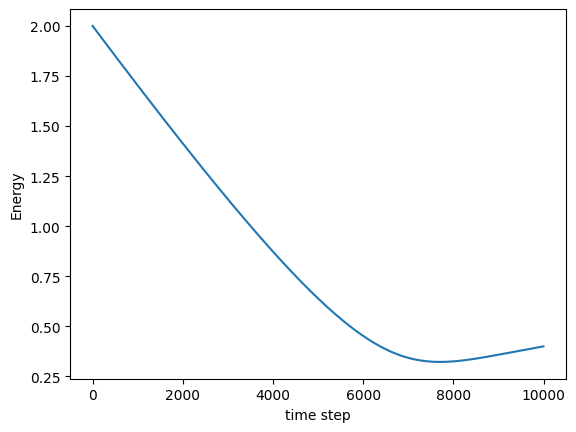

In [13]:
import matplotlib.pyplot as plt
plt.plot(gap_values)
plt.xlabel("time step")
plt.ylabel("Energy")
plt.show()